In [1]:
import datetime
from collections import Counter

import pandas as pd
import numpy as np
import seaborn as sb

from sklearn.feature_selection import SelectKBest, chi2, f_classif

import matplotlib.pyplot as plt
%matplotlib inline

random_seed = 42

In [2]:
# Загрузка общей выборки
data = pd.read_csv('../data/2/tula_yarobl_finished.csv', converters={'okpd': str})
print('Размер выборки (строки, столбцы): {}'.format(data.shape))
data.head(5)

Размер выборки (строки, столбцы): (37997, 27)


,Unnamed: 0,cntrID,org_cntr_num,org_1s_sev,org_1s_sup_sev,sup_cntr_num,sup_cntr_avg_price,sup_cntr_avg_penalty,sup_no_pnl_share,sup_okpd_exp,...,price_higher_pmp,price_too_low,price,pmp,okpd,type_prod,cntr_lvl,sign_date,exec_date,cntr_result
0,0,480853,177,0.0,0.0,292,51386,0.0,1.0,1.0,...,0,0,15985.44,15985.44,0,19,3,20150112,20150331,0
1,1,480867,431,0.0,0.0,6,171863,0.0,1.0,1.0,...,0,0,98355.00,98850.00,0,19,3,20150110,20151231,0
2,2,481366,621,0.0,0.0,287,215299,0.0,1.0,1.0,...,0,0,82724.30,83140.00,0,19,2,20150112,20151231,0
3,3,481425,773,0.0,0.0,1,90000,0.0,1.0,1.0,...,0,0,90000.00,90000.00,0,19,2,20150112,20151231,0
4,4,481812,76,0.0,0.0,365,201042,0.0,1.0,1.0,...,0,0,107440.10,107980.00,0,19,2,20150114,20150430,0


In [3]:
# Загрузка выборки по контрактам федерального уровня
grbs = pd.read_csv('../data/2/tula_yarobl_grbs_finished.csv', converters={'okpd': str})
print('Размер выборки (строки, столбцы): {}'.format(grbs.shape))
grbs.head(5)

Размер выборки (строки, столбцы): (24912, 27)


,Unnamed: 0,cntrID,org_cntr_num,org_1s_sev,org_1s_sup_sev,sup_cntr_num,sup_cntr_avg_price,sup_cntr_avg_penalty,sup_no_pnl_share,sup_okpd_exp,...,price_higher_pmp,price_too_low,price,pmp,okpd,type_prod,cntr_lvl,sign_date,exec_date,cntr_result
0,0,1505399,141,0.0,0.0,1,262800,0.0,1.0,1.0,...,0,0,262800.00,265230.9,0,-1,1,20150101,20151231,1
1,1,1505542,164,0.0,0.0,2,336037,0.0,1.0,1.0,...,0,0,433100.00,714000.0,0,-1,1,20150112,20151231,1
2,2,1505554,581,0.0,0.0,2,198450,0.0,1.0,1.0,...,0,0,152100.00,152100.0,0,-1,1,20150112,20150131,1
3,3,1505963,2157,0.0,0.0,4,269765,0.0,1.0,0.5,...,0,0,50000.00,50000.0,0,-1,1,20150112,20150126,1
4,4,1505984,598,0.0,0.0,8,521224,0.0,1.0,1.0,...,0,0,998007.17,1013361.0,0,-1,1,20150112,20151231,1


In [4]:
# Чистка данных
for df in (data, grbs):
    # Удаление лишнего столбца и столбцов с некорректными данными
    df.drop(['Unnamed: 0', 'type_prod', 'sup_1s_sev'], inplace=True, axis=1)
    # Удаление контрактов, у которых не указана дата окончания
    df.drop(df[df.exec_date == -1].index, inplace=True)
    
# удаление контрактов федерального уровня из общей выдорки
data.drop(data[data.cntr_lvl == 1].index, inplace=True)

print('Размер общей выборки: {}'.format(data.shape))
print('Размер выборки по ГРБС: {}'.format(grbs.shape))

Размер общей выборки: (35175, 24)
Размер выборки по ГРБС: (24912, 24)


### Описание переменных
1. org_cntr_num - количество завершенных контрактов у заказчика
2. org_1s_sup_sev - доля контрактов у заказчика с односторонним разрывом со стороны поставщика
3. sup_cntr_num - количество завершенных контрактов у поставщика
4. sup_cntr_avg_price - средняя цена контрактов у поставщика
5. sup_cntr_avg_penalty - средняя доля пени от цены контрактов у поставщика
6. sup_no_pnl_share - доля контрактов без штрафов у поставщика
7. sup_okpd_exp - доля контрактов с OKPD2, совпадающим с OKPD2 текущего контракта
8. sup_1s_sev - доля контрактов поставщика с его односторонним разрывом
9. sup_1s_org_sev - доля контрактов поставщика с односторонним разрывом со стороны заказчика
10. sup_sim_price - доля контрактов поставщика с ценой, отличающейся от цены текущего контракта на менее 20%
11. sup_type - тип поставщика (из таблицы fx_OOS_PartType)
12. sup_status - статус поставщика (из таблицы fx_OOS_StatusSup)
13. org_form - форма организации заказчика (из таблицы fx_OOS_OrgForm)
14. org_type - тип организации заказчика (из таблицы d_oos_TypeOrg)
15. price_higher_pmp - 1, если цена больше МНЦК, 0 - иначе
16. price_too_low - 1, если цена меньше МНЦК на более 40%, 0 - иначе
17. price - цена контракта
18. pmp - НМЦК контракта
19. okpd - ОКПД2 контракта
20. cntr_lvl - уровень контракта (федеральный, муниципальный, субъекта РФ)
21. sign_date - дата начала контракта
22. exec_date - дата окончания исполнения контракта
23. cntr_result - результат контракта (0 - плохой контракт, 1 - хороший)

In [5]:
# количественные переменнные
num_var = [
    'org_cntr_num', 'sup_cntr_num', 
    'sup_cntr_avg_price', 
    'price', 'pmp'
]

# количественные переменные принимающие значения на отрезке [0, 1]
num_var01 = [
    'org_1s_sev', 'org_1s_sup_sev', 'sup_cntr_avg_penalty',
    'sup_no_pnl_share', 'sup_okpd_exp', 
    'sup_1s_org_sev', 'sup_sim_price'
]

# категориальные небинарные переменные
cat_var = [
    'sup_type', 'sup_status', 'org_form', 'org_type',
    'okpd', 'cntr_lvl'
]

# категориальные бинарные переменные
cat_bin_var = [
    'price_higher_pmp', 'price_too_low'
]

### Анализ количественных переменных

In [6]:
# Описательные статистики (среднее, стадартное отклонение, квартили)
data[num_var].describe()

,org_cntr_num,sup_cntr_num,sup_cntr_avg_price,price,pmp
count,35175.000000,35175.000000,3.517500e+04,3.517500e+04,3.517500e+04
mean,551.810405,2170.847875,5.965473e+05,7.214968e+05,7.804636e+05
std,765.546682,3077.907994,9.684446e+06,9.883065e+06,1.018377e+07
min,1.000000,1.000000,0.000000e+00,1.000000e-02,0.000000e+00
25%,106.000000,18.000000,8.500500e+04,3.191277e+04,3.414175e+04
50%,227.000000,242.000000,1.447320e+05,9.552060e+04,1.021274e+05
75%,770.000000,4307.000000,2.659210e+05,3.131204e+05,3.603726e+05
max,6408.000000,7651.000000,1.151663e+09,1.151663e+09,1.205930e+09


In [7]:
# Описательные статистики (среднее, стадартное отклонение, квартили)
grbs[num_var].describe()

,org_cntr_num,sup_cntr_num,sup_cntr_avg_price,price,pmp
count,24912.000000,24912.000000,2.491200e+04,2.491200e+04,2.491200e+04
mean,500.855491,52.369099,5.111849e+05,4.791068e+05,5.358166e+05
std,451.668492,311.426197,3.139880e+06,2.371213e+06,2.441703e+06
min,1.000000,1.000000,0.000000e+00,1.000000e-02,0.000000e+00
25%,197.000000,1.000000,8.271200e+04,5.707810e+04,7.200000e+04
50%,370.000000,5.000000,1.711670e+05,1.470840e+05,1.791170e+05
75%,653.000000,24.000000,3.618880e+05,3.872952e+05,4.521859e+05
max,2236.000000,7651.000000,2.059000e+08,2.059000e+08,2.074000e+08


In [8]:
# Мода (наиболее часто встречающееся значение)
# Название переменной: мода на общей выборке, мода на выборке по контрактам федерального уровня
for nv in num_var:
    print('{}: {}, {}'.format(nv, data[nv].mode()[0], grbs[nv].mode()[0]))

org_cntr_num: 260, 1387
sup_cntr_num: 7651, 1
sup_cntr_avg_price: 144732, 355931
price: 4594368.88, 200000.0
pmp: 0.0, 100000.0


**Во-первых**, в общей выборке (ОВ) максимальное количество контрактов у заказчика и 75 перцентиль больше чем на выборке по федеральным контрактам (ВФК), а также больше среднее. Это означает, что в ОВ у заказчика в целом больше опыт участия в госзакупках, чем в ВФК. **Во-вторых**, контракты федерального уровня исполняют гораздо менее опытные поставщики (25, 50, 75 перцентили отличаются в 10 раз).

In [9]:
num_var_cntr = list(num_var)
num_var_cntr.append('cntr_result')

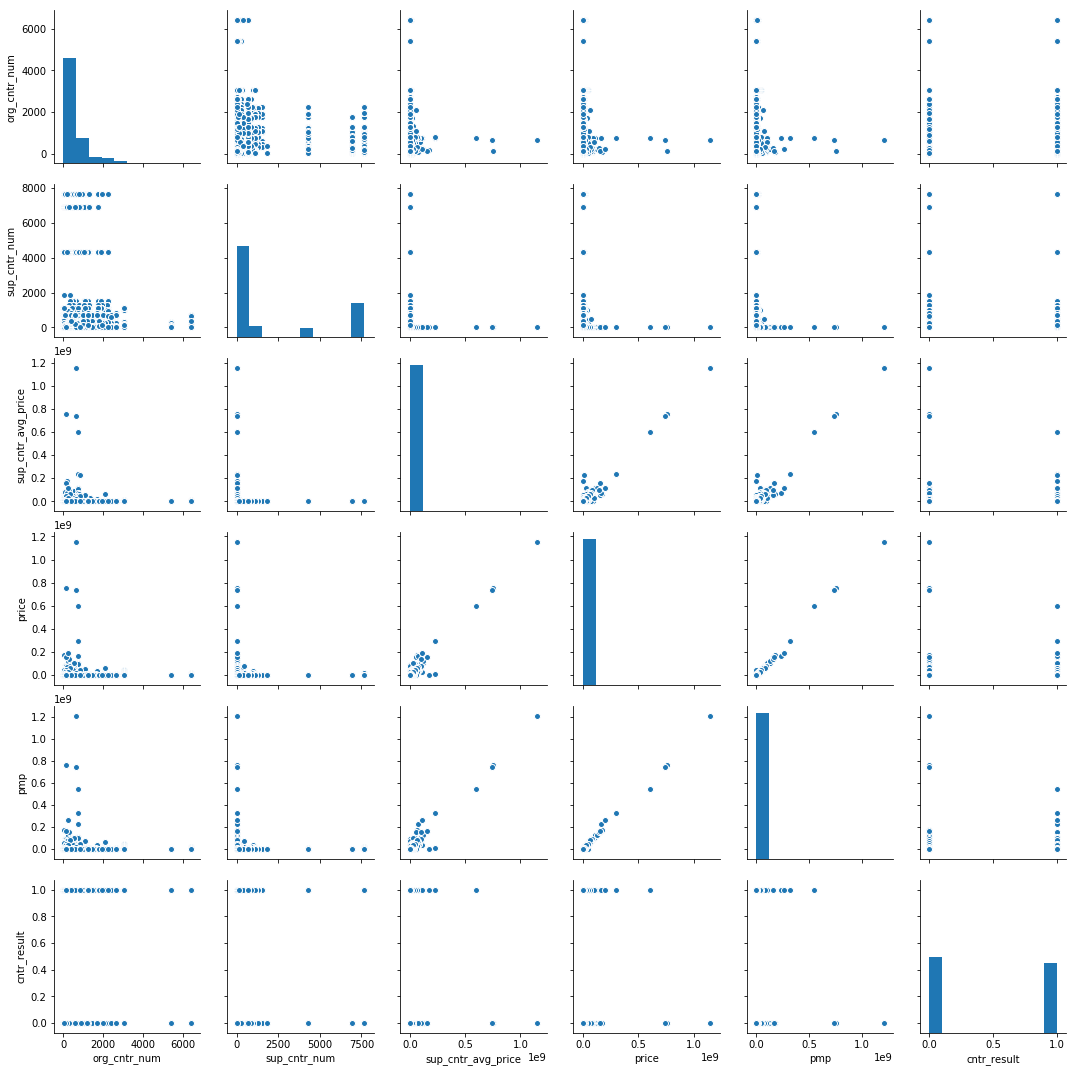

In [10]:
# Гистограммы всех количественных переменных и графики попарных зависимостей
sb.pairplot(data[num_var_cntr])

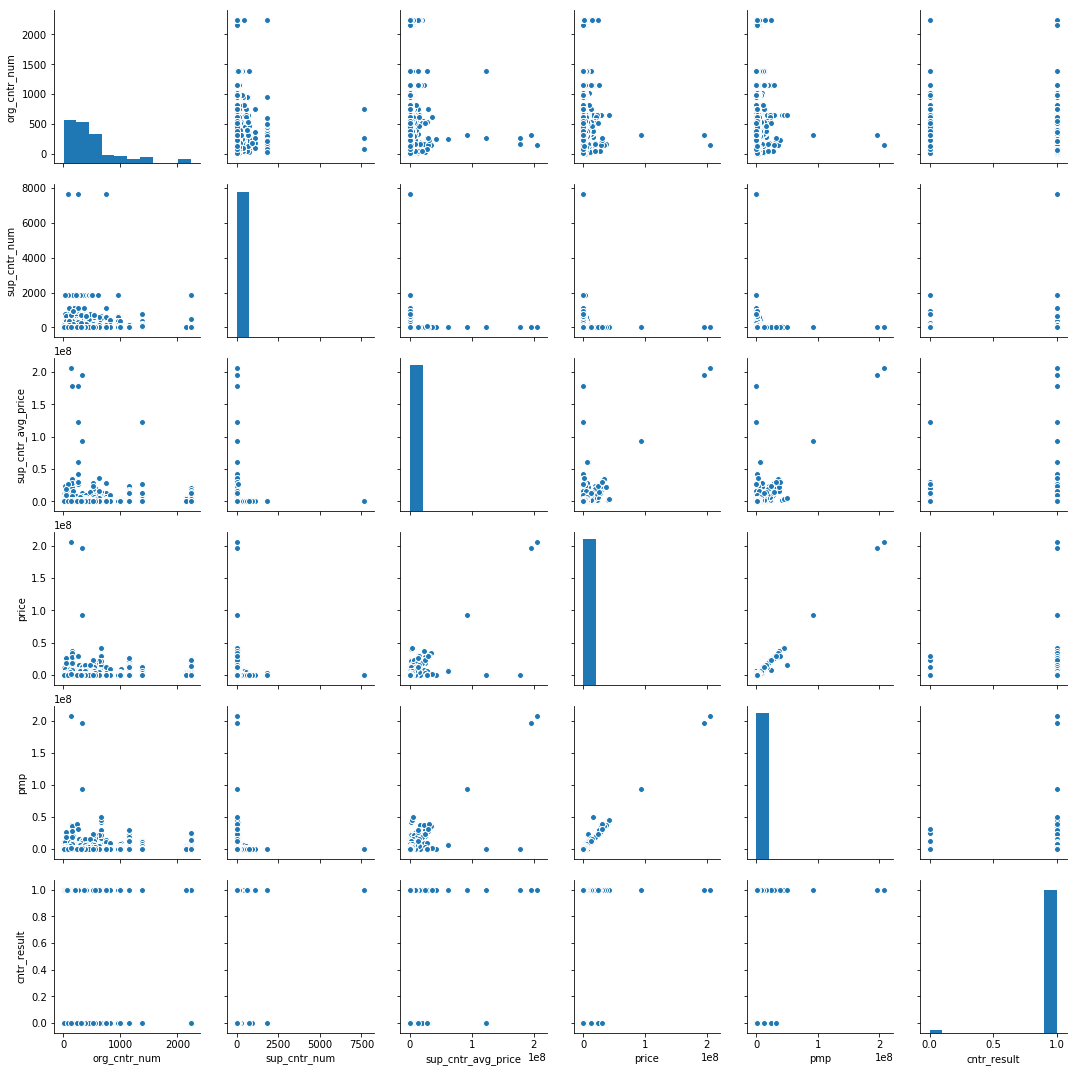

In [11]:
# Гистограммы всех количественных переменных и графики попарных зависимостей
sb.pairplot(grbs[num_var_cntr])

**Замечание**. Имеет смысл прологарифмировать все количественные переменные, так как они имеют большие правые хвосты.

In [12]:
# Линейная корреляция количественных переменных между собой и с целевой переменной
data[num_var_cntr].corr()

,org_cntr_num,sup_cntr_num,sup_cntr_avg_price,price,pmp,cntr_result
org_cntr_num,1.000000,-0.265748,0.008944,0.005792,0.006036,0.304914
sup_cntr_num,-0.265748,1.000000,-0.033323,-0.011277,-0.012248,-0.490550
sup_cntr_avg_price,0.008944,-0.033323,1.000000,0.962870,0.956657,0.004695
price,0.005792,-0.011277,0.962870,1.000000,0.996931,-0.008850
pmp,0.006036,-0.012248,0.956657,0.996931,1.000000,-0.009270
cntr_result,0.304914,-0.490550,0.004695,-0.008850,-0.009270,1.000000


**Выводы**
1. Признаки org_cntr_num и sup_cntr_num являются важными, так как имеют большую корреляцию с результатом.
2. Корреляция между pmp, price и sup_cntr_avg_price очень велика, во время предобработки данных необходимо исключить переменные, сильно коррелирующие друг с другом переменных.

In [13]:
# Корреляция количественных переменных между собой и с целевой переменной
grbs[num_var_cntr].corr()

,org_cntr_num,sup_cntr_num,sup_cntr_avg_price,price,pmp,cntr_result
org_cntr_num,1.000000,-0.062036,0.043671,0.072189,0.069319,-0.031541
sup_cntr_num,-0.062036,1.000000,-0.011609,-0.010153,-0.012154,0.006785
sup_cntr_avg_price,0.043671,-0.011609,1.000000,0.643778,0.635363,-0.030488
price,0.072189,-0.010153,0.643778,1.000000,0.991408,-0.010387
pmp,0.069319,-0.012154,0.635363,0.991408,1.000000,-0.011040
cntr_result,-0.031541,0.006785,-0.030488,-0.010387,-0.011040,1.000000


Переменные, которые имеют большую корреляцию с результатом на ОВ, не имеют корреляции с результатом для ВФК.

In [14]:
# Логарифмирование всех количественных переменных для подтягивания правого хвоста
for nv in num_var:
    for df in (data, grbs):
        df.loc[df[nv]<1, nv] = 1
        df[nv] = np.log(df[nv])

In [15]:
data[num_var].describe()

,org_cntr_num,sup_cntr_num,sup_cntr_avg_price,price,pmp
count,35175.000000,35175.000000,35175.000000,35175.000000,35175.000000
mean,5.540363,5.273436,12.008607,11.508557,11.368798
std,1.319792,2.954623,1.082926,1.780711,2.558213
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.663439,2.890372,11.350465,10.370762,10.438276
50%,5.424950,5.488938,11.882639,11.467097,11.533976
75%,6.646391,8.367997,12.490955,12.654343,12.794894
max,8.765302,8.942592,20.864473,20.864473,20.910517


In [16]:
grbs[num_var].describe()

,org_cntr_num,sup_cntr_num,sup_cntr_avg_price,price,pmp
count,24912.000000,24912.000000,24912.000000,24912.000000,24912.000000
mean,5.830592,1.978099,12.142171,11.941764,12.066055
std,0.942659,1.784624,1.222388,1.392662,1.640640
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.283204,0.000000,11.323120,10.952176,11.184421
50%,5.913503,1.609438,12.050395,11.898759,12.095795
75%,6.481577,3.178054,12.799090,12.866942,13.021849
max,7.712444,8.942592,19.142901,19.142901,19.150160


**Выводы**
1. Как отмечалось ранее, контракты федерального уровня реализуют гораздо менее опытный поставщики (см. разницу между средним (mean) sup_cntr_num для ОВ и ВФК. 
2. Значения переменных по контрактам федерального уровня имеют меньшую дисперсию. 
3. В остальном характеристики количественных переменных для ОВ и ВФК похожи.

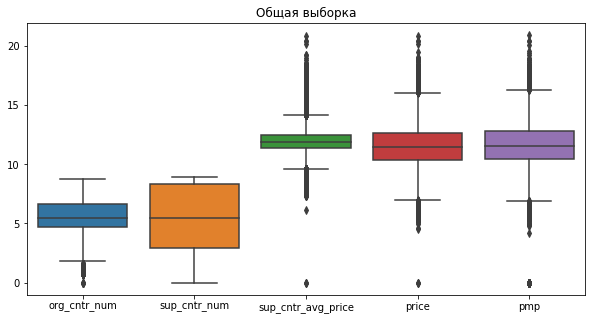

In [17]:
# Ящик с усами (https://datavizcatalogue.com/RU/metody/diagramma_razmaha.html)
# Ящик с усами - визуальная форма представления основных описательных статистик
fig = plt.figure(figsize = (10,5))
ax = fig.gca()
ax.set_title('Общая выборка')
sb.boxplot(data=data[num_var], ax=ax)

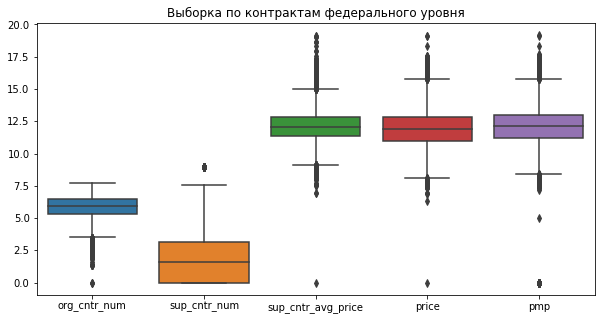

In [18]:
fig = plt.figure(figsize = (10,5))
ax = fig.gca()
ax.set_title('Выборка по контрактам федерального уровня')
sb.boxplot(data=grbs[num_var], ax=ax)

### Анализ количественных переменных с областью значений [0, 1]

In [19]:
# Исправление максимальных значений sup_okpd_exp, которое не может быть больше 1
data.loc[data['sup_okpd_exp'] > 1, 'sup_okpd_exp'] = 1
grbs.loc[grbs['sup_okpd_exp'] > 1, 'sup_okpd_exp'] = 1

In [20]:
data[num_var01].describe()

,org_1s_sev,org_1s_sup_sev,sup_cntr_avg_penalty,sup_no_pnl_share,sup_okpd_exp,sup_1s_org_sev,sup_sim_price
count,35175.000000,35175.000000,35175.000000,35175.000000,35175.000000,35175.000000,35175.000000
mean,0.000179,0.000043,0.000036,0.999774,0.552980,0.000008,0.197268
std,0.003053,0.001050,0.001467,0.004403,0.432386,0.000751,0.259197
min,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,0.055290,0.000000,0.063390
50%,0.000000,0.000000,0.000000,1.000000,0.636360,0.000000,0.104040
75%,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.176470
max,0.111110,0.142860,0.120910,1.000000,1.000000,0.090910,1.000000


In [21]:
grbs[num_var01].describe()

,org_1s_sev,org_1s_sup_sev,sup_cntr_avg_penalty,sup_no_pnl_share,sup_okpd_exp,sup_1s_org_sev,sup_sim_price
count,24912.000000,24912.000000,24912.000000,24912.000000,24912.000000,24912.000000,24912.000000
mean,0.000354,0.000018,0.000061,0.998642,0.549063,0.000007,0.450869
std,0.001097,0.000459,0.002086,0.029423,0.399314,0.000747,0.367593
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,0.136990,0.000000,0.133330
50%,0.000000,0.000000,0.000000,1.000000,0.500000,0.000000,0.333330
75%,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
max,0.007520,0.020830,0.265200,1.000000,1.000000,0.083330,1.000000


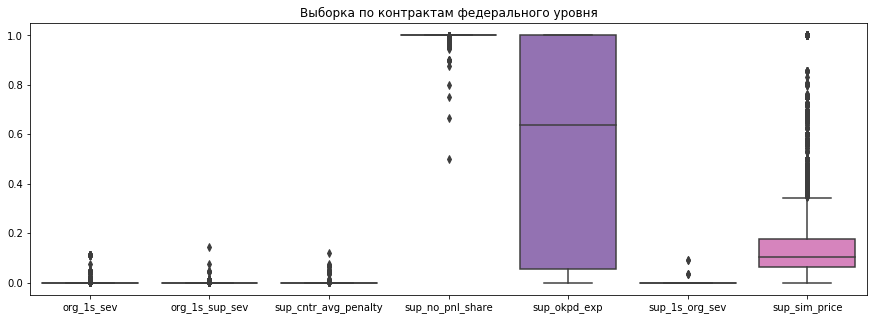

In [22]:
fig = plt.figure(figsize = (15,5))
ax = fig.gca()
ax.set_title('Выборка по контрактам федерального уровня')
sb.boxplot(data=data[num_var01], ax=ax)

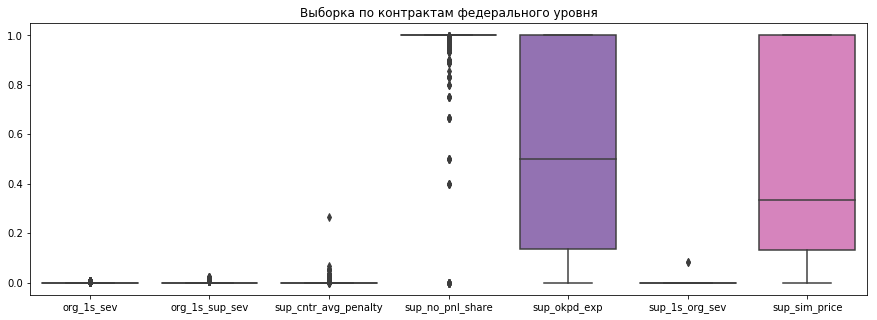

In [23]:
fig = plt.figure(figsize = (15,5))
ax = fig.gca()
ax.set_title('Выборка по контрактам федерального уровня')
sb.boxplot(data=grbs[num_var01], ax=ax)

In [24]:
num_var01_cntr = list(num_var01)
num_var01_cntr.append('cntr_result')

In [25]:
data[num_var01_cntr].corr()

,org_1s_sev,org_1s_sup_sev,sup_cntr_avg_penalty,sup_no_pnl_share,sup_okpd_exp,sup_1s_org_sev,sup_sim_price,cntr_result
org_1s_sev,1.000000,0.017694,-0.000171,-0.001965,0.038609,0.007363,0.026388,0.011194
org_1s_sup_sev,0.017694,1.000000,-0.000012,0.001049,0.018621,-0.000438,0.021844,0.021338
sup_cntr_avg_penalty,-0.000171,-0.000012,1.000000,-0.294330,-0.001372,-0.000262,-0.002582,-0.015737
sup_no_pnl_share,-0.001965,0.001049,-0.294330,1.000000,-0.005953,0.000548,0.008094,0.004972
sup_okpd_exp,0.038609,0.018621,-0.001372,-0.005953,1.000000,0.002565,0.372486,0.695851
sup_1s_org_sev,0.007363,-0.000438,-0.000262,0.000548,0.002565,1.000000,-0.003999,-0.003369
sup_sim_price,0.026388,0.021844,-0.002582,0.008094,0.372486,-0.003999,1.000000,0.194681
cntr_result,0.011194,0.021338,-0.015737,0.004972,0.695851,-0.003369,0.194681,1.000000


In [26]:
grbs[num_var01_cntr].corr()

,org_1s_sev,org_1s_sup_sev,sup_cntr_avg_penalty,sup_no_pnl_share,sup_okpd_exp,sup_1s_org_sev,sup_sim_price,cntr_result
org_1s_sev,1.000000,-0.012728,-0.006838,0.009625,0.048899,-0.002894,0.043295,0.022392
org_1s_sup_sev,-0.012728,1.000000,-0.001158,0.001819,0.007412,-0.000353,0.002632,0.006057
sup_cntr_avg_penalty,-0.006838,-0.001158,1.000000,-0.325319,-0.007856,-0.000263,0.000615,0.004376
sup_no_pnl_share,0.009625,0.001819,-0.325319,1.000000,-0.019068,0.000414,-0.033744,-0.001477
sup_okpd_exp,0.048899,0.007412,-0.007856,-0.019068,1.000000,-0.001101,0.748059,0.006164
sup_1s_org_sev,-0.002894,-0.000353,-0.000263,0.000414,-0.001101,1.000000,-0.007944,0.001377
sup_sim_price,0.043295,0.002632,0.000615,-0.033744,0.748059,-0.007944,1.000000,-0.001710
cntr_result,0.022392,0.006057,0.004376,-0.001477,0.006164,0.001377,-0.001710,1.000000


**Выводы**
1. Все переменные кроме sup_sim_price имеют похожие значения описательные статистик на ОВ и ВФК.
2. На ОВ переменные sup_okpd_exp и sup_sim_price имеют большую корреляцию с целевой переменной, остальные не имеют линейной корреляции с cntr_result.
3. На ВФК все переменные практически не коррелирую с целевой переменной.

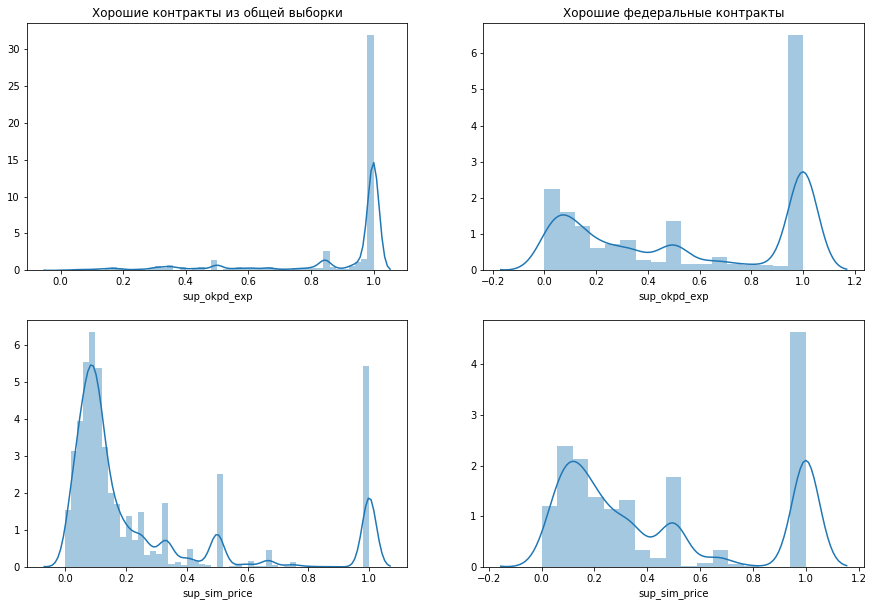

In [27]:
# Распределение значений переменных (гистограмма) sup_okpd_exp и sup_sim_price для хороших контрактов по ОВ и ВФК
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.set_title('Хорошие контракты из общей выборки')
ax2.set_title('Хорошие федеральные контракты')

sb.distplot(data.loc[data.cntr_result==1]['sup_okpd_exp'], ax=ax1)
sb.distplot(grbs.loc[grbs.cntr_result==1]['sup_okpd_exp'], ax=ax2)
sb.distplot(data.loc[data.cntr_result==1]['sup_sim_price'], ax=ax3)
sb.distplot(grbs.loc[grbs.cntr_result==1]['sup_sim_price'], ax=ax4)

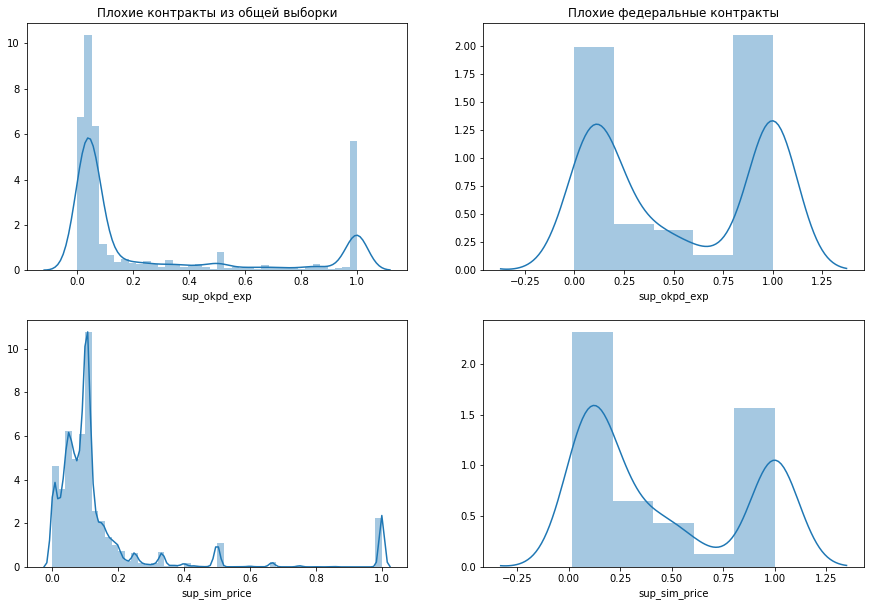

In [28]:
# Распределение значений переменных (гистограмма) sup_okpd_exp и sup_sim_price для плохих контрактов по ОВ и ВФК
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.set_title('Плохие контракты из общей выборки')
ax2.set_title('Плохие федеральные контракты')

sb.distplot(data.loc[data.cntr_result==0]['sup_okpd_exp'], ax=ax1)
sb.distplot(grbs.loc[grbs.cntr_result==0]['sup_okpd_exp'], ax=ax2)
sb.distplot(data.loc[data.cntr_result==0]['sup_sim_price'], ax=ax3)
sb.distplot(grbs.loc[grbs.cntr_result==0]['sup_sim_price'], ax=ax4)

**Выводы.** 
1. Переменная sup_sim_price имеет похожие распределение для плохих и хороших контрактов по ОВ и ВФК
2. Переменная sup_okpd_exp имеет разные распределени. Заметно, что хорошие контракты по ОВ в основном выполняются максимально опытными поставщиками, в то время как хорошие федеральные контракты часто выполняются гораздо менее опытными поставщиками 

### Анализ категориальных переменных

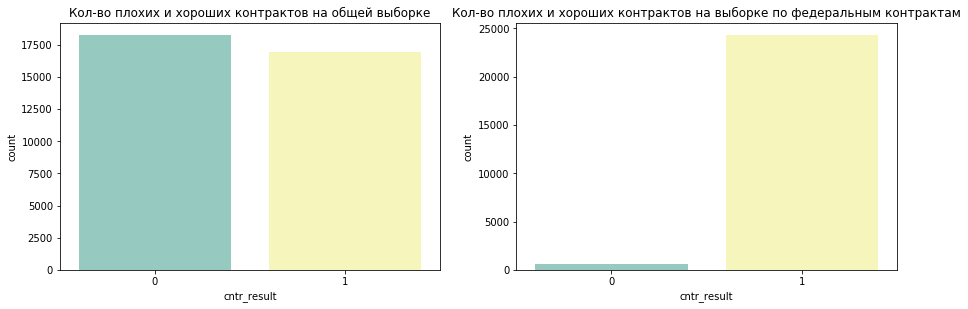

In [29]:
fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)

ax1.set_title('Кол-во плохих и хороших контрактов на общей выборке')
ax2.set_title('Кол-во плохих и хороших контрактов на выборке по федеральным контрактам')

sb.countplot(x='cntr_result', data=data, palette='Set3', ax=ax1)
sb.countplot(x='cntr_result', data=grbs, palette='Set3', ax=ax2)

In [30]:
# Количество значений категориальных переменных
# Название переменной: кол-во значений на общей выборке, кол-во значений на выборке по контрактам федерального уровня
for cv in cat_var:
    print('{}: {}, {}'.format(cv, len(set(data[cv])), len(set(grbs[cv]))))

sup_type: 5, 4
sup_status: 7, 5
org_form: 77, 64
org_type: 16, 16
okpd: 979, 2407
cntr_lvl: 3, 1


**Замечение**. Контракты федерального уровня являются гораздо более разнонаправленными по сфере. Количество уникальных ОКПД2 в ВФК в 2,5 раза больше, чем в ОВ.

In [31]:
def cntr_distrib_over_cat_var(df, cat_var, fig_width=20, percent=True):
    """Распределение плохих и хороших контрактов по категориальной переменной cat_var"""
    
    total, bad, good = Counter(), Counter(), Counter()
    l, t, b, g = [], [], [], []

    for row in df[[cat_var, 'cntr_result']].itertuples():
        total[row[1]] += 1
        if row[2]:
            good[row[1]] += 1
        else:
            bad[row[1]] += 1

    for val in set(df[cat_var]):
        l.append(val)
        t.append(total.get(val))
        b.append(bad.get(val, 0))
        g.append(good.get(val, 0))

    df = pd.DataFrame({cat_var: l, 'bad': b, 'good': g, 'total': t}) 
    
    r = range(len(l))
    fig = plt.figure(figsize=(fig_width,5))
    ax = plt.subplot(111)
    plt.xticks(r, l)
    plt.xlabel(cat_var)
    
    if percent:
        df['bad_p'] = df['bad'] / df['total']
        df['good_p'] = df['good'] / df['total']

        ax.bar(r, df['bad_p'], color='#FF665F', edgecolor='white', label='Плохие контракты')
        ax.bar(r, df['good_p'], bottom=df['bad_p'], color='#5FFF92', edgecolor='white', label='Хорошие контракты')
        plt.ylabel("Доля")
        plt.title("Доля плохих и хороших контрактов в зависимости от {}".format(cat_var))
    else:
        ax.bar(r, df['bad'], color='#FF665F', edgecolor='white', label='Плохие контракты')
        ax.bar(r, df['good'], bottom=df['bad'], color='#5FFF92', edgecolor='white', label='Хорошие контракты')
        plt.ylabel("Количество")
        plt.title("Количество плохих и хороших контрактов в зависимости от {}".format(cat_var))
    
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [32]:
# Создание двух новых переменных: год и месяц начала контракта
data['sign_year'] = data['sign_date'].apply(lambda a: pd.Series(int(str(a)[:4])))
data['sign_month'] = data['sign_date'].apply(lambda a: pd.Series(int(str(a)[4:6])))

grbs['sign_year'] = grbs['sign_date'].apply(lambda a: pd.Series(int(str(a)[:4])))
grbs['sign_month'] = grbs['sign_date'].apply(lambda a: pd.Series(int(str(a)[4:6])))

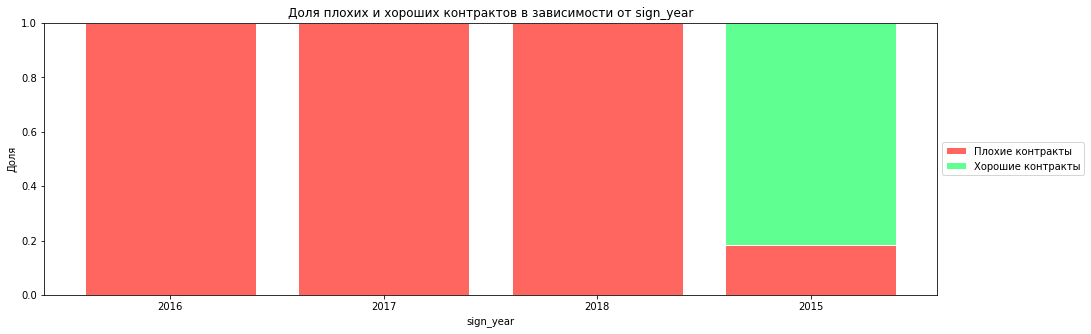

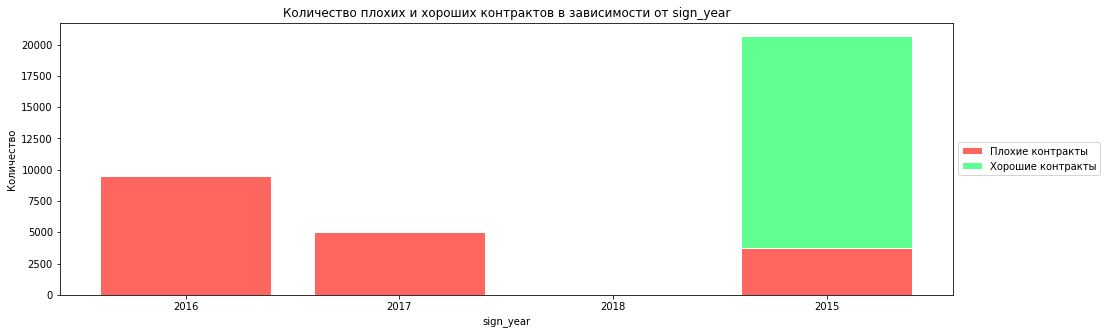

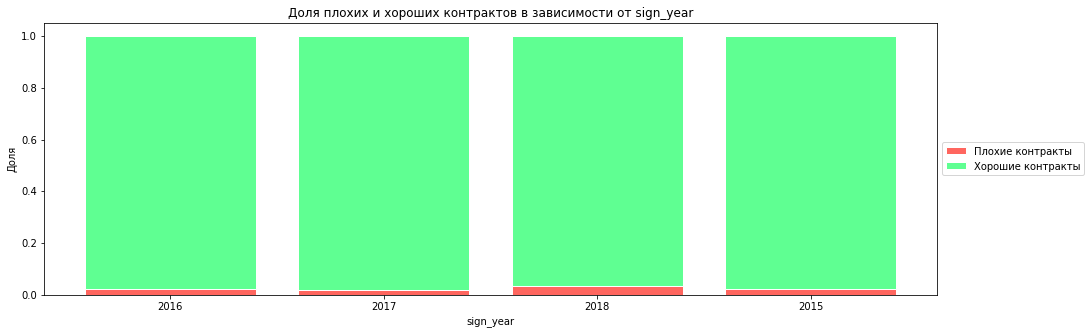

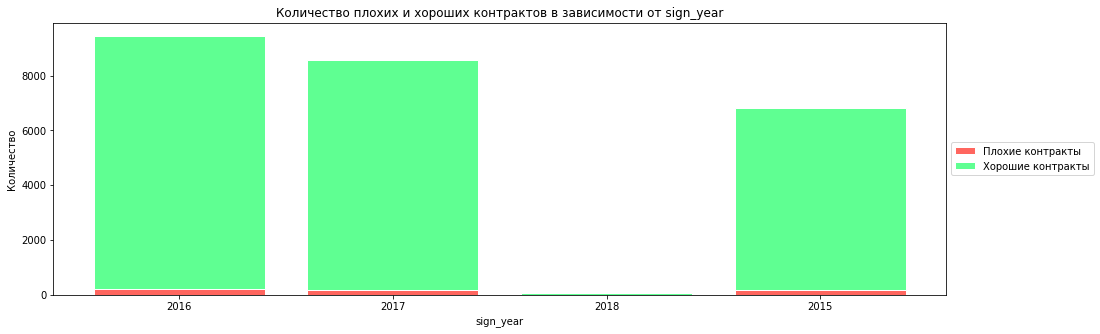

In [33]:
# Распределение хороших и плохих контрактов по категориальной переменной sign_year (год начала контракта)
# Сначала для ОВ, затем для ВФК
cntr_distrib_over_cat_var(data, 'sign_year')
cntr_distrib_over_cat_var(data, 'sign_year', percent=False)
cntr_distrib_over_cat_var(grbs, 'sign_year')
cntr_distrib_over_cat_var(grbs, 'sign_year', percent=False)

**Выводы**
1. На ОВ в данных наблюдается необычная закономерность: хорошие контракты присутствуют только в 2015 году.
2. На ВФК какой-то закономерности не выделяется

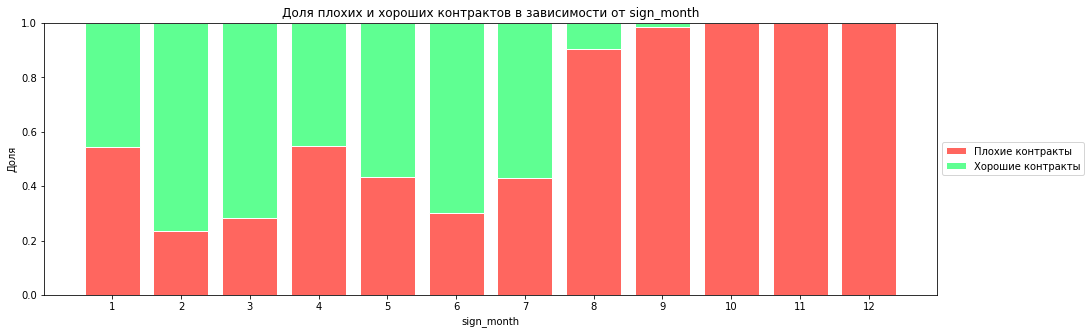

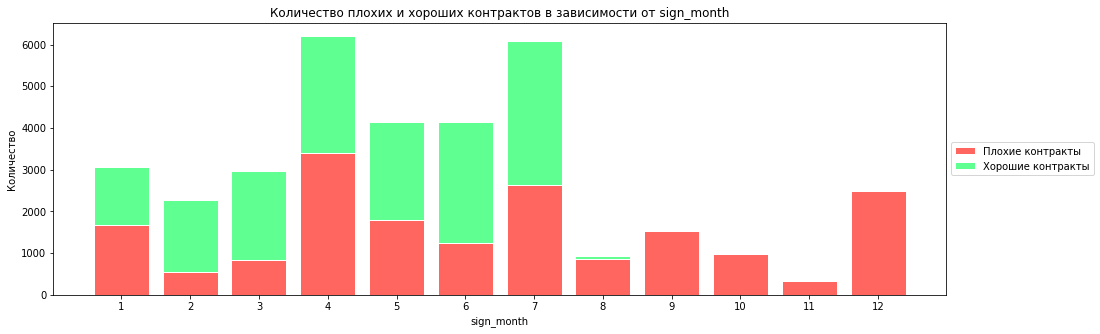

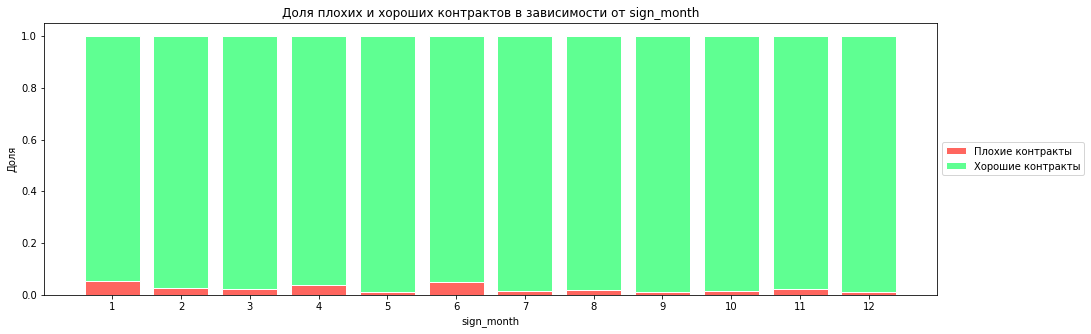

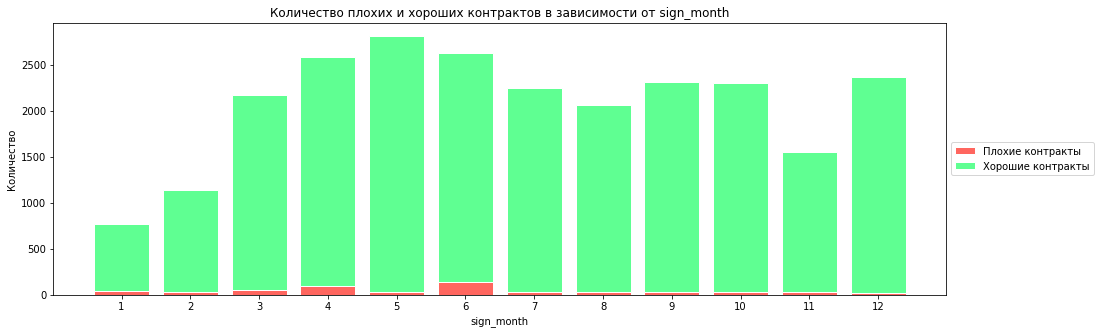

In [34]:
cntr_distrib_over_cat_var(data, 'sign_month')
cntr_distrib_over_cat_var(data, 'sign_month', percent=False)
cntr_distrib_over_cat_var(grbs, 'sign_month')
cntr_distrib_over_cat_var(grbs, 'sign_month', percent=False)

**Выводы**
1. На ОВ контракты, заключенные после 7 месяца (июля), практически все являются плохими.
2. На ВФК какой-то закономерности не выделяется.

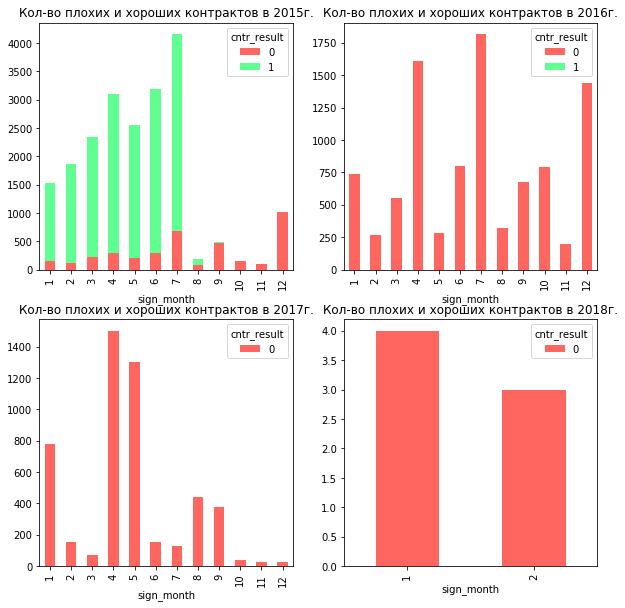

In [35]:
# Количество контрактов по месяцам для каждого года по ОВ
fig = plt.figure(figsize=(10,10))
for idx, year in enumerate((2015, 2016, 2017, 2018)):
    ax = fig.add_subplot(220 + idx + 1)
    data[data['sign_year']==year].groupby(['sign_month', 'cntr_result'])['cntr_result'].count().unstack().plot(
        kind='bar', 
        stacked=True,
        title='Кол-во плохих и хороших контрактов в {}г.'.format(year), 
        color=['#FF665F', '#5FFF92'],
        ax=ax
    )

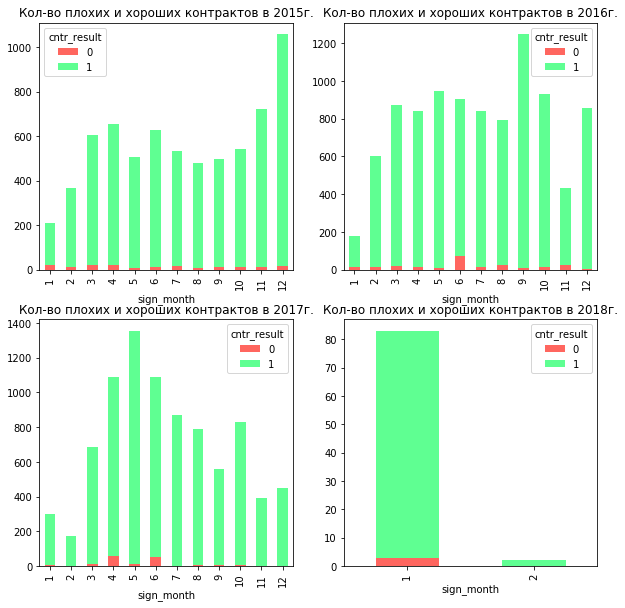

In [36]:
# Количество контрактов по месяцам для каждого года по ВФК
fig = plt.figure(figsize=(10,10))
for idx, year in enumerate((2015, 2016, 2017, 2018)):
    ax = fig.add_subplot(220 + idx + 1)
    grbs[grbs['sign_year']==year].groupby(['sign_month', 'cntr_result'])['cntr_result'].count().unstack().plot(
        kind='bar', 
        stacked=True,
        title='Кол-во плохих и хороших контрактов в {}г.'.format(year), 
        color=['#FF665F', '#5FFF92'],
        ax=ax
    )

**Замечение**. Отмечается различная сезонность (тренд, распределение количество контрактов по месяцам) между ОВ и ВФК.

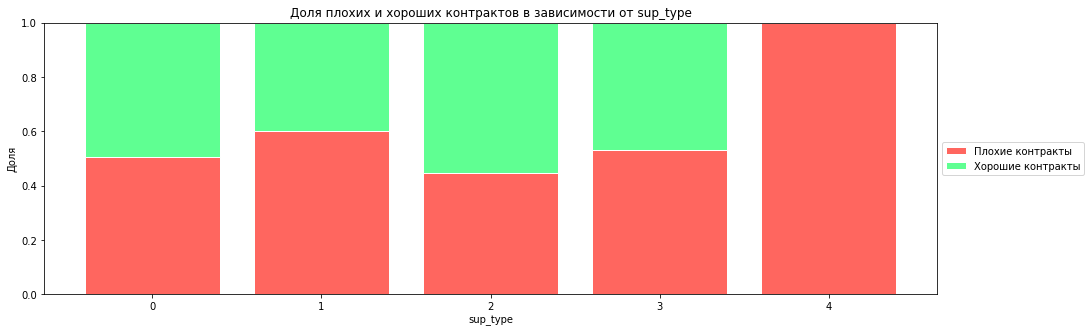

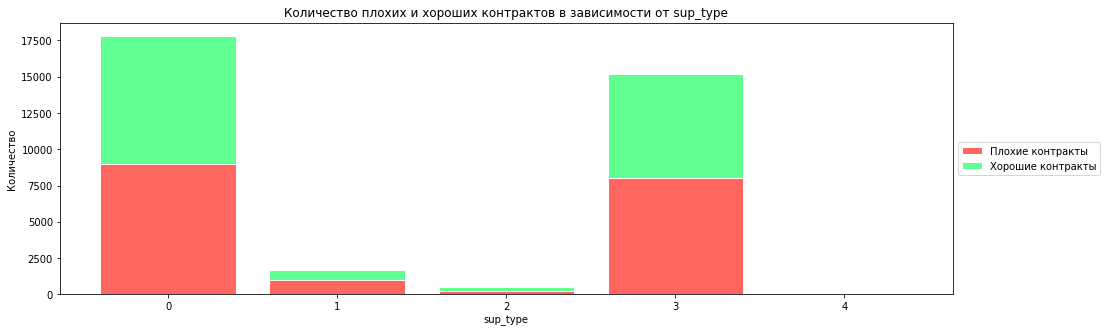

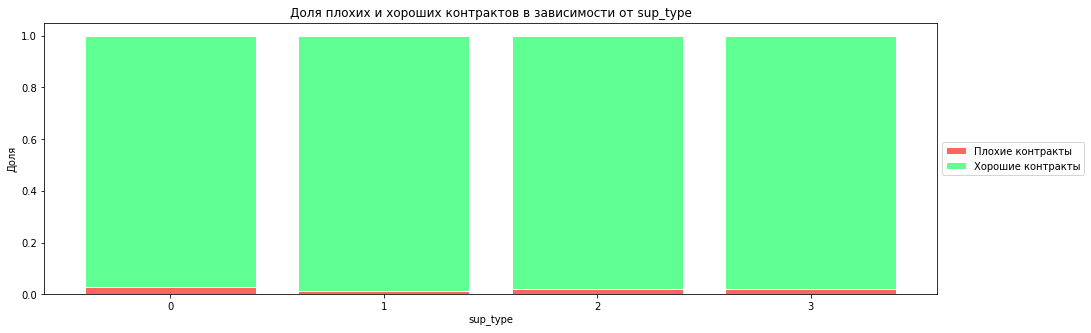

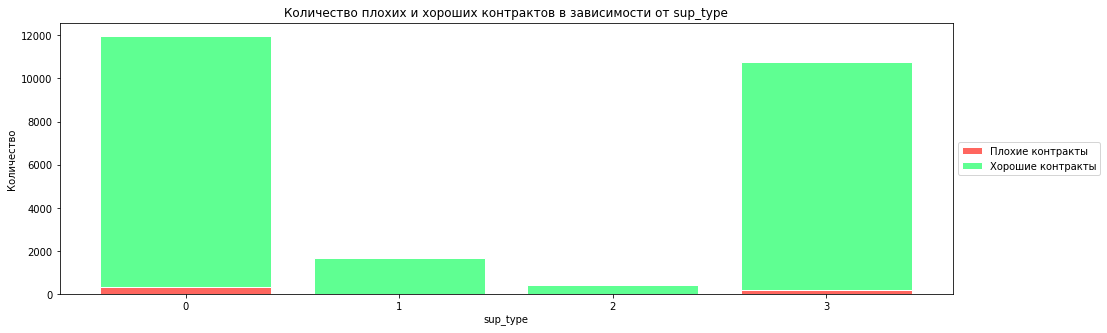

In [37]:
cntr_distrib_over_cat_var(data, 'sup_type')
cntr_distrib_over_cat_var(data, 'sup_type', percent=False)
cntr_distrib_over_cat_var(grbs, 'sup_type')
cntr_distrib_over_cat_var(grbs, 'sup_type', percent=False)

**Замечение**. Для федеральных контрактов также часто как и на ОВ не указан тип поставщика (0) и лидирует 3 тип (Юридическое лицо РФ)

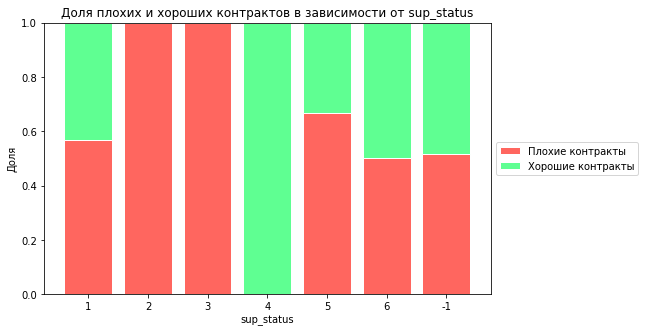

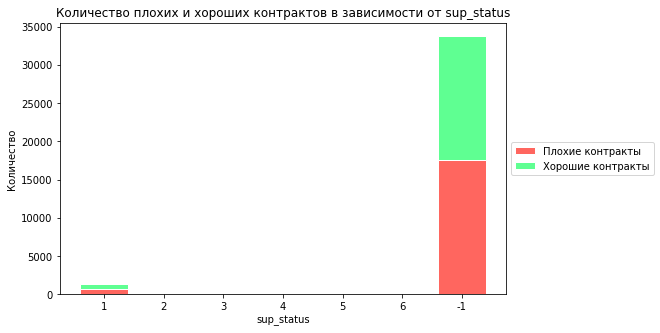

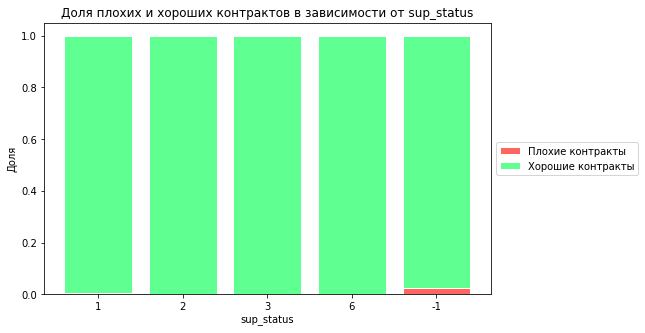

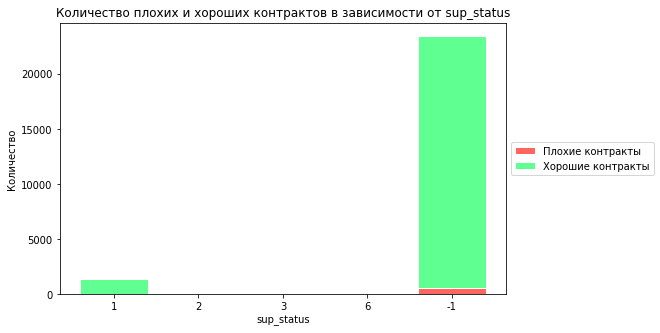

In [38]:
cntr_distrib_over_cat_var(data, 'sup_status', fig_width=10)
cntr_distrib_over_cat_var(data, 'sup_status', percent=False, fig_width=10)
cntr_distrib_over_cat_var(grbs, 'sup_status', fig_width=10)
cntr_distrib_over_cat_var(grbs, 'sup_status', percent=False, fig_width=10)

**Замечение**. Распределение контрактов по статусу поставщика в ВФК похоже на распределение в ОВ. Много контрактов с неуказанным статусом поставщика. Лидирует такой статус поставщика, как субъект малого предпринимательства (1).

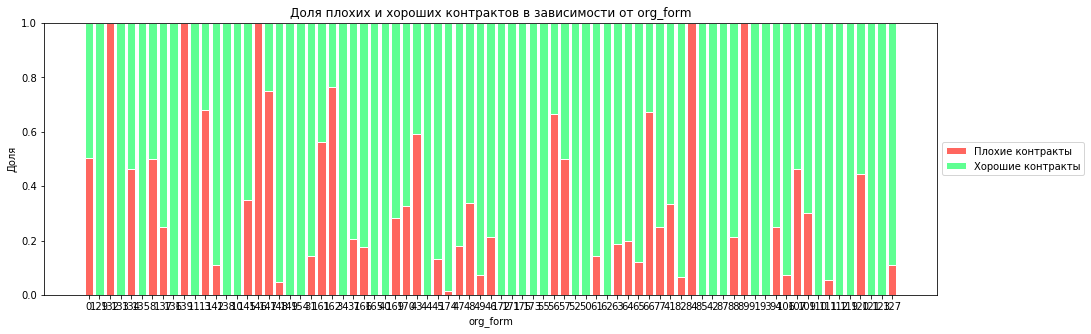

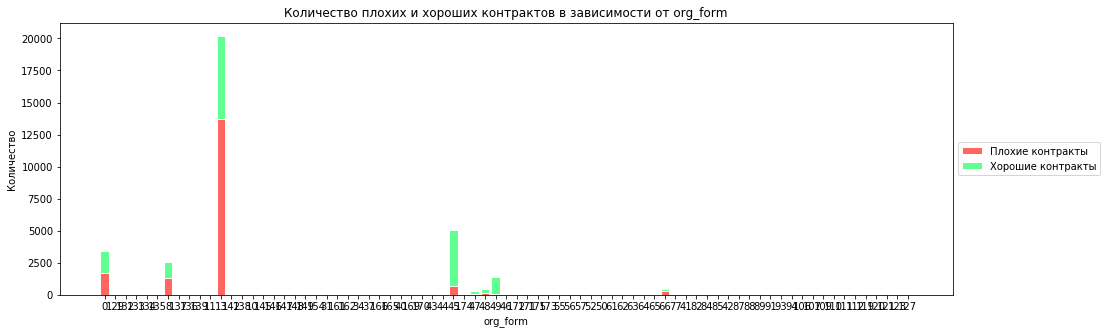

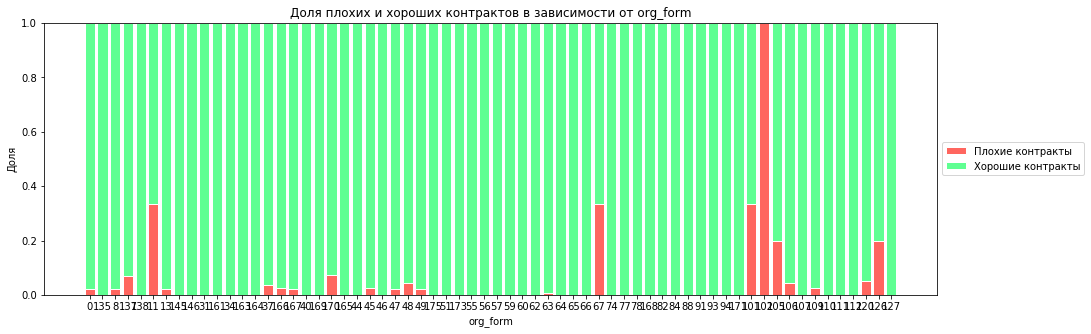

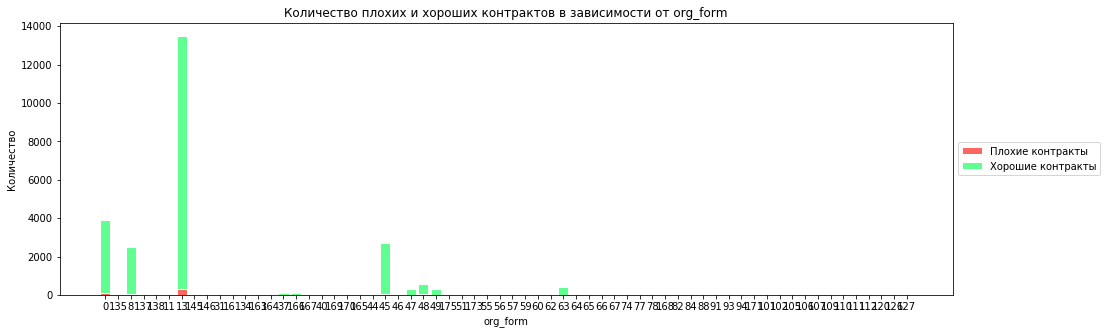

In [39]:
cntr_distrib_over_cat_var(data, 'org_form')
cntr_distrib_over_cat_var(data, 'org_form', percent=False)
cntr_distrib_over_cat_var(grbs, 'org_form')
cntr_distrib_over_cat_var(grbs, 'org_form', percent=False)

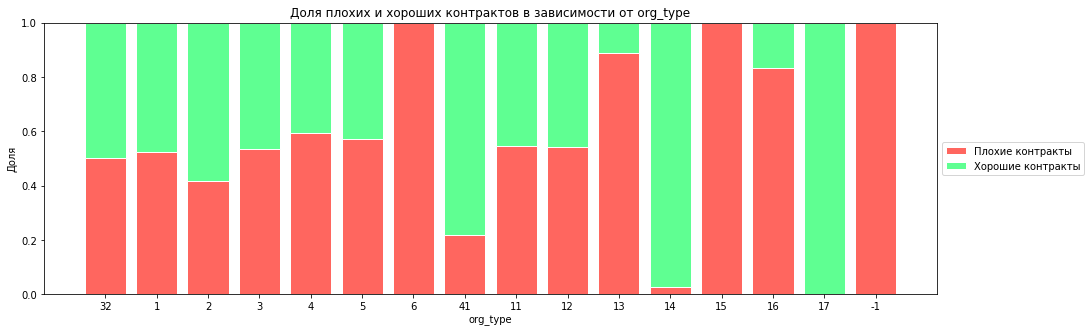

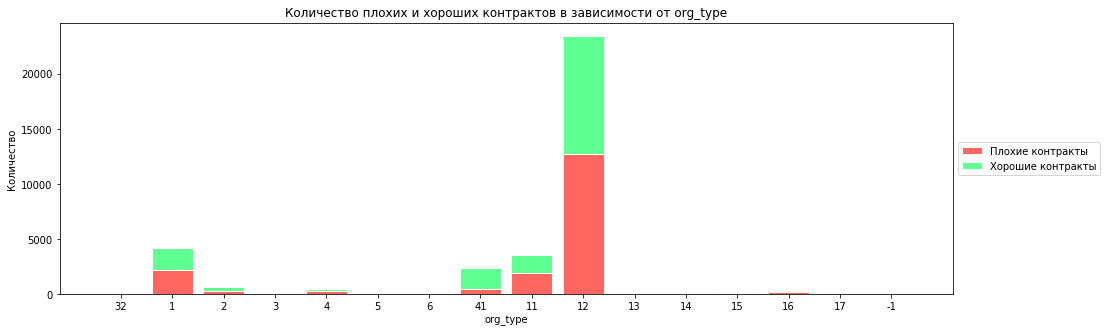

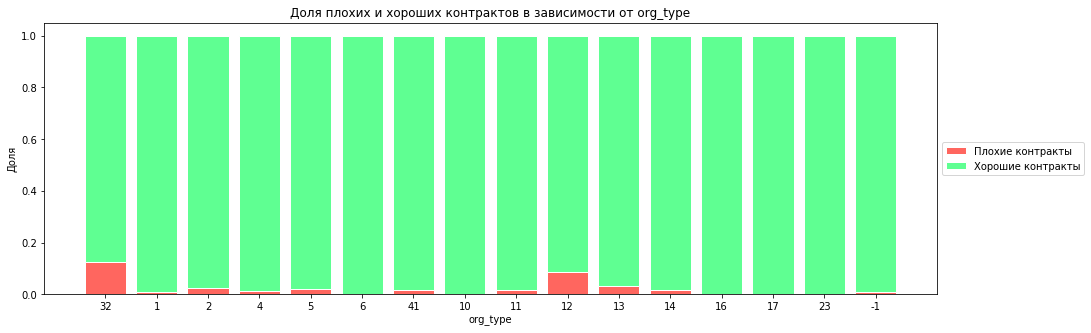

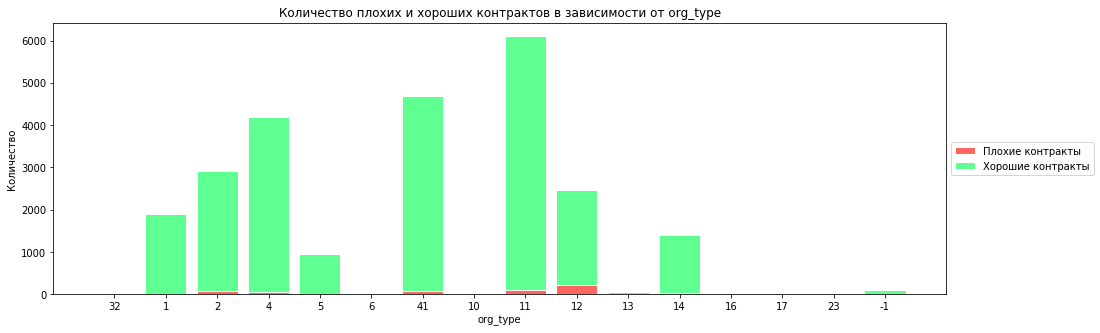

In [40]:
cntr_distrib_over_cat_var(data, 'org_type')
cntr_distrib_over_cat_var(data, 'org_type', percent=False)
cntr_distrib_over_cat_var(grbs, 'org_type')
cntr_distrib_over_cat_var(grbs, 'org_type', percent=False)

**Замечение**. В ОВ больше всего контрактов от бюджетных учреждений (1, 12). За ним следуют федеральный ОГВ (11) и органы государственной власти (41). Распределение контрактов по типу организаций заказчиков в ВФК сильно отличается (не удивительно).

In [41]:
# Создание новой переменной, отвечающей за первые два символа ОКПД2
data['okpd_class'] = data['okpd'].apply(lambda a: pd.Series(a[:2]))
grbs['okpd_class'] = grbs['okpd'].apply(lambda a: pd.Series(a[:2]))

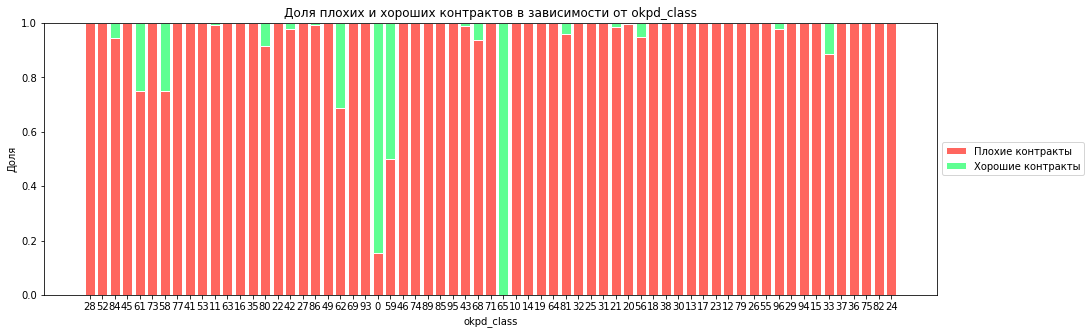

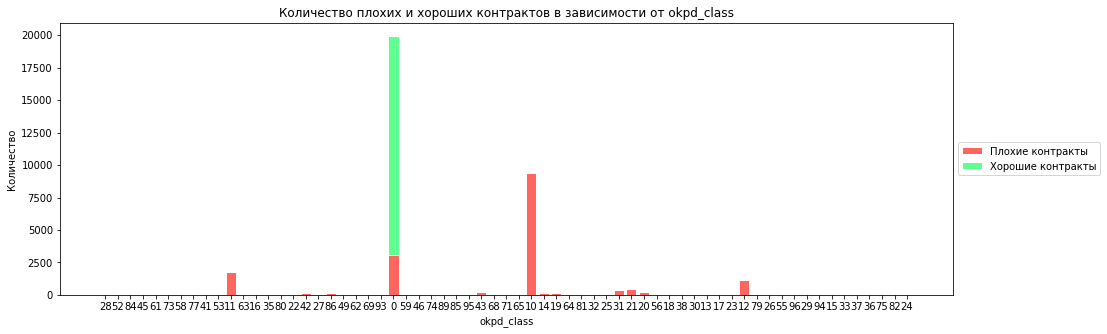

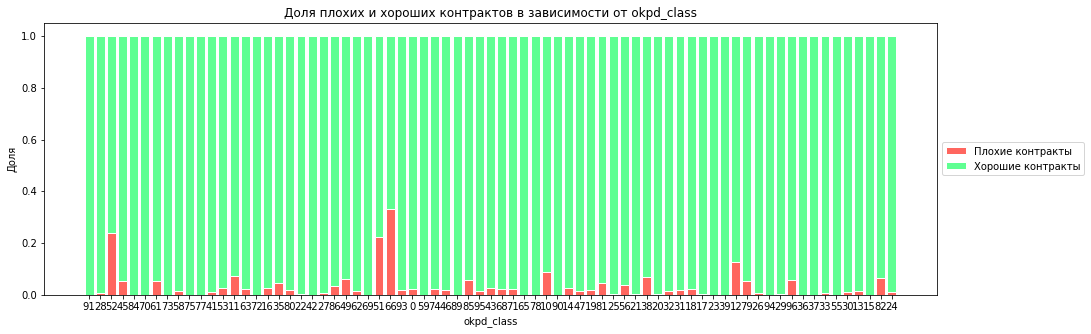

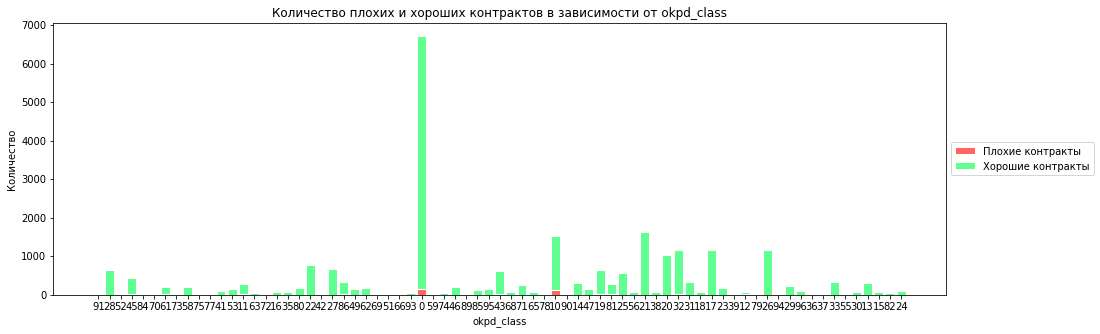

In [42]:
cntr_distrib_over_cat_var(data, 'okpd_class')
cntr_distrib_over_cat_var(data, 'okpd_class', percent=False)
cntr_distrib_over_cat_var(grbs, 'okpd_class')
cntr_distrib_over_cat_var(grbs, 'okpd_class', percent=False)

**Замечение**. В ОВ больше всего неблагонадежных контрактов в таких сферах, как 12 (изделия табачные), 10 (продукты пищевые), 11 (напитки). Распределение как общего количества контрактов, так и плохих контратков федерального уровня отличается от данных по ОВ.

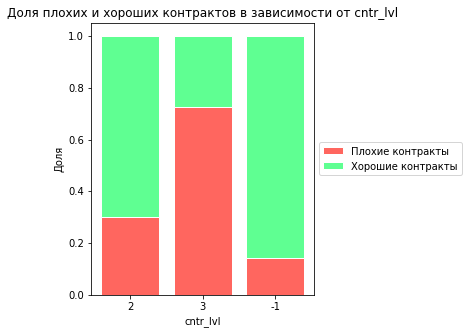

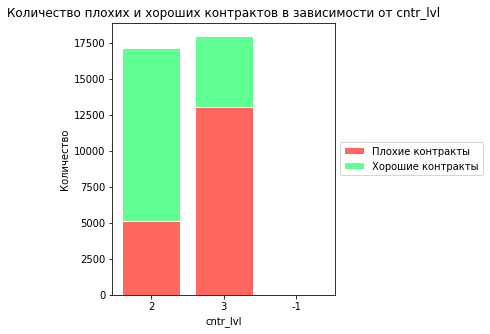

In [43]:
# Распределение контрактов в ОВ по уровню контратов
cntr_distrib_over_cat_var(data, 'cntr_lvl', fig_width=5)
cntr_distrib_over_cat_var(data, 'cntr_lvl', fig_width=5, percent=False)

**Замечение**. Заметно, что плохих контрактов на муниципальном уровне (3) существенно больше, чем на уровне субъекта РФ.

### Анализ категориальных бинарных переменных

In [44]:
cat_bin_var_cntr = list(cat_bin_var)
cat_bin_var_cntr.append('cntr_result')

In [45]:
data[cat_bin_var_cntr].corr()

,price_higher_pmp,price_too_low,cntr_result
price_higher_pmp,1.000000,-0.029315,0.026022
price_too_low,-0.029315,1.000000,0.115995
cntr_result,0.026022,0.115995,1.000000


In [46]:
grbs[cat_bin_var_cntr].corr()

,price_higher_pmp,price_too_low,cntr_result
price_higher_pmp,1.000000,-0.053395,0.021245
price_too_low,-0.053395,1.000000,0.022003
cntr_result,0.021245,0.022003,1.000000


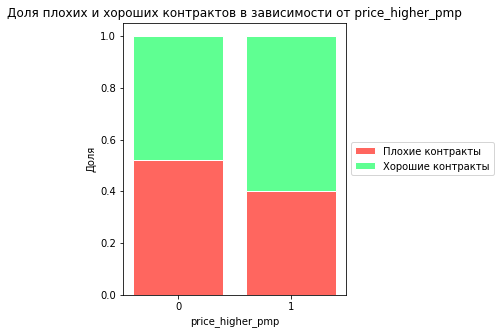

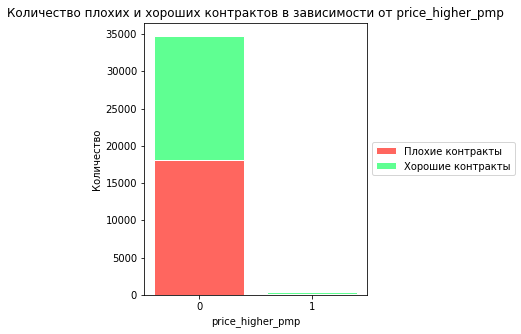

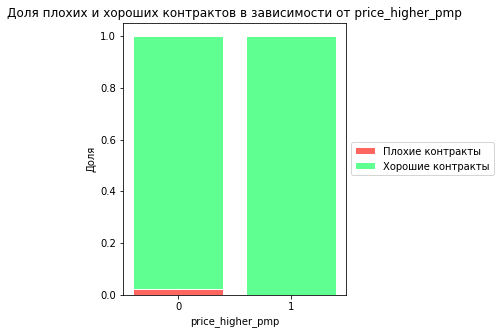

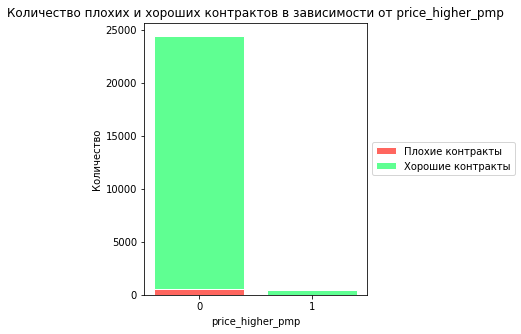

In [47]:
cntr_distrib_over_cat_var(data, 'price_higher_pmp', fig_width=5)
cntr_distrib_over_cat_var(data, 'price_higher_pmp', fig_width=5, percent=False)
cntr_distrib_over_cat_var(grbs, 'price_higher_pmp', fig_width=5)
cntr_distrib_over_cat_var(grbs, 'price_higher_pmp', fig_width=5, percent=False)

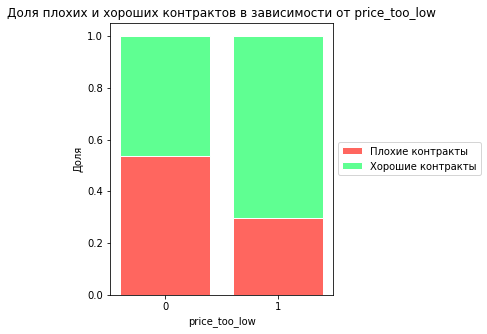

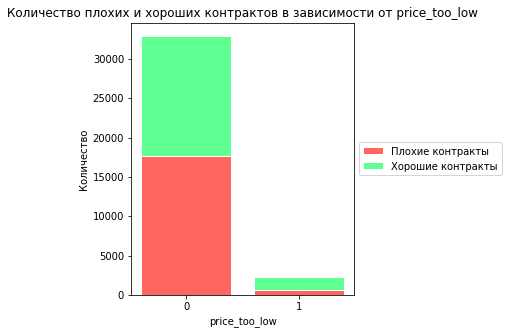

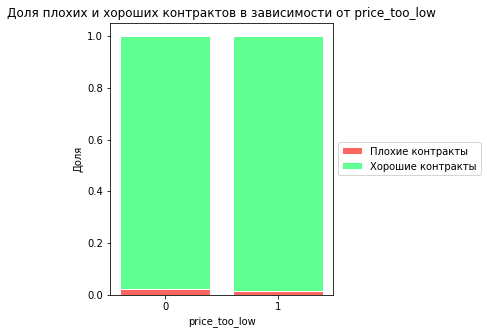

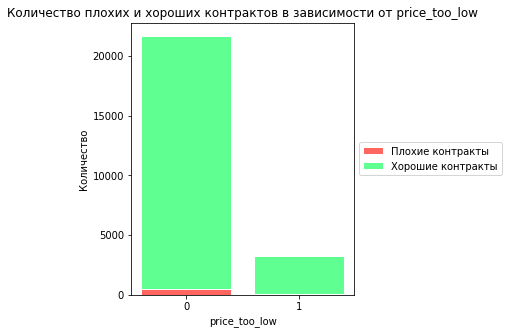

In [48]:
cntr_distrib_over_cat_var(data, 'price_too_low', fig_width=5)
cntr_distrib_over_cat_var(data, 'price_too_low', fig_width=5, percent=False)
cntr_distrib_over_cat_var(grbs, 'price_too_low', fig_width=5)
cntr_distrib_over_cat_var(grbs, 'price_too_low', fig_width=5, percent=False)

**Выводы.** 
1. Редко наблюдаются случаи, когда цена выше МНЦК (price_higher_pmp). 
2. Когда этот критерий срабатывает, доля хороших контрактов не уменьшается, а наоборот увеличивается. 
3. Аналогичные размышления верны для переменной price_too_low и данных как из ОВ, так и из ВФК.

### Выбор признаков

**Обзор**. В данной части будет добавлено несколько дополнительных признаков, которые мне показались интересными. А затем будет произведена оценена важность всех признаков на ОВ и ВФК отличными от линейной корреляции методами (Хи-квардрат, ANOVA). Результаты в самом конце.

In [50]:
# Добавляем такие признаки как длина контракта, год начала контракта, месяц начала контракта.
for df in (data, grbs):
    cntr_start = df['sign_date'].apply(lambda a: pd.Series(datetime.datetime.strptime(str(a), "%Y%m%d").date()))
    cntr_end = df['exec_date'].apply(lambda a: pd.Series(datetime.datetime.strptime(str(a), "%Y%m%d").date()))

    df['cntr_length'] = (cntr_end - cntr_start)[0].apply(lambda a: pd.Series(int(str(a).split()[0])))
    df['sign_year'] = df['sign_date'].apply(lambda a: pd.Series(int(str(a)[:4])))
    df['sign_month'] = df['sign_date'].apply(lambda a: pd.Series(int(str(a)[4:6])))

    # Удаляем такие контракты, у которых дата начала и окончания совпадает
    df.drop(df[df.cntr_length == 0].index, inplace=True)

In [51]:
# Пропущенные значения заменяем на самые популярные
# Исправляем случаи, когда одни и те же значения переменной обозначаются разными числами
for df in (data, grbs):
    df.loc[df.sup_type == 0, 'sup_type'] = 3
    df.loc[(df.org_form == 45) | (df.org_form == 0), 'org_form'] = 13
    df.loc[(df.org_type == 1) | (df.org_type == -1), 'org_type'] = 12
    df.loc[df.cntr_lvl == -1, 'cntr_lvl'] = 3

In [52]:
# Формируем признаки
X = data.drop(['cntrID', 'cntr_result', 'okpd', 'sign_date', 'exec_date', 'sup_status'], axis=1)
X_grbs = grbs.drop(['cntrID', 'cntr_result', 'okpd', 'sign_date', 'exec_date', 'sup_status', 'cntr_lvl'], axis=1)

columns = X.columns
columns_grbs = X_grbs.columns

# Целевая переменная
y = data.cntr_result.values
y_grbs = grbs.cntr_result.values

In [53]:
def rate_feature_importance(X_values, y_values, func_list, columns, alias=''):
    """Функция для тестирования важности признаков"""
    
    result_dict = {}
    result_list = []
    
    for func in func_list:
        test = SelectKBest(score_func=func)
        fit = test.fit(X_values, y_values)
        res = sorted(
            dict(zip(columns, [e for e in list(fit.scores_)])).items(),
            key=lambda a: a[1],
            reverse=True
        )
        
        func_name = str(func).split()[1]
        dict_key = '{}_{}'.format(alias, func_name) if alias else func_name
        
        result_dict[dict_key] = [i[0] for i in res]
        result_list.append(res)
    
    return pd.DataFrame(result_dict), result_list

In [54]:
# Оценка важности переменных для ОВ и ВФК
res_data, _ = rate_feature_importance(X.values, y, [chi2, f_classif], columns, alias='data')
res_grbs, _ = rate_feature_importance(X_grbs.values, y_grbs, [chi2, f_classif], columns_grbs, alias='grbs')

In [55]:
# 5 наиболее важных переменных для ОВ и ВФК в порядке убывания важности
res_data.join(res_grbs).head()

,data_chi2,data_f_classif,grbs_chi2,grbs_f_classif
0,okpd_class,sign_year,cntr_length,cntr_length
1,org_form,sup_okpd_exp,org_form,price
2,sup_cntr_num,okpd_class,sign_month,sign_month
3,sup_okpd_exp,cntr_lvl,org_type,sup_cntr_avg_price
4,sign_month,sup_cntr_num,price,org_cntr_num


**Выводы** Важные признаки при использовании обоих методов для ОВ и данным по федеральным контрактам отличаются несущественно.

### Общие выводы
Данные по контрактам федерального уровня и общей выборки отличаются, что приводит к большим ошибкам при применении модели, обученной на общей выборке, к контрактам федерального уровня. 

Необходимо ли строить отдельные модели для контрактов муниципального уровня, уровня субъекта РФ и федерального уровня? Это пока открытый вопрос, буду пробовать все подходы. Окончательное решение буду принимать, после проведения исследований на бОльшем объеме данных.